In [2]:
import numpy as np
import pandas as pd
import nltk
import multiprocessing
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
nltk.download('wordnet')
nltk.download('stopwords')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.corpus import stopwords
import twint
import nest_asyncio
import matplotlib.pyplot as plt
nest_asyncio.apply()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jflit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jflit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
c = twint.Config()
c.Search= 'bitcoin'

c.Min_likes = 10
c.Count = True
c.Since = "2022-05-16"
c.Store_csv = True # This is for storing file in csv format (if you want in json file it will be c.Store_json=True)
c.Output = 'recent.csv'

_ = twint.run.Search(c)

CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 1.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 8.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 27.0 secs


### Import it into dataframe

In [3]:
df = pd.read_csv('bitcoin.csv')

df = df[df["language"]=="en"] #Get rid of non-english tweets
# dropping all the duplicates tweets and keeping only the first values
df = df.drop_duplicates(subset="tweet",keep="first")
df = df[['date', 'tweet']]
df.reset_index(inplace=True, drop=True)

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Data processing down to lemma form

In [4]:
def lemmatize_text(text):
    return list([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [5]:
df['tweet'] = df['tweet'].astype(str)
df['tweet'] = df['tweet'].str.lower()  # Make everything lowercase
df['tweet'] = df['tweet'].str.replace(r'[^a-z\s]', '', regex=True)  # Remove anything not numeric

df['lemmatized'] = df.tweet.apply(lemmatize_text)  # Lemmatize each word

df['lemmatized'] = pd.DataFrame(df.lemmatized.tolist()).fillna('').astype(str).agg(' '.join, 1)  # Concatenate the lemmatized words
df = df[df['lemmatized'].notna()]
df = df[df["lemmatized"].str.contains("bitcoin")]  # Get rid of rows where the word bitcoin isnt present in the tweet

stop = stopwords.words('english')
pat = r'\b(?:{})\b'.format('|'.join(stop))  # Create regex pattern from stopwords
df['no_stop'] = df['lemmatized'].str.replace(pat, '', regex=True)  # Remove stop words
df['no_stop'] = df['no_stop'].str.replace(r'\s+', ' ', regex=True)  # Remove spaces more than one space

df['no_stop'] = df.no_stop.apply(lemmatize_text)  # Lemmatize each word again

df.reset_index(inplace=True, drop=True)
df['prepped'] = pd.DataFrame(df.lemmatized.tolist()).fillna('').astype(str).agg(' '.join, 1)

### Save part of dataframe as test

In [6]:
test = df[0:2000]
df = df[2000:]
test.to_pickle('test.pickle')
df.to_pickle('train.pickle')

In [7]:
w2v = Word2Vec(min_count=4,
                window=5,
                vector_size=300,
                sample=1e-5,
                alpha=0.03,
                min_alpha=0.0007,
                negative=20,
                seed=42,
                workers=multiprocessing.cpu_count()-2)

w2v.build_vocab(df.no_stop, progress_per=500)

In [10]:
w2v.train(df.no_stop, total_examples=len(df), epochs=20, report_delay=1)
w2v.wv.most_similar(positive=['sell'])

[('buy', 0.7424719333648682),
 ('buying', 0.7241766452789307),
 ('everytime', 0.7078250050544739),
 ('thinkingbitmex', 0.6941163539886475),
 ('tanked', 0.692104697227478),
 ('salty', 0.6790027022361755),
 ('dumped', 0.6757903099060059),
 ('dip', 0.6717361211776733),
 ('jerryxfeng', 0.671116828918457),
 ('liquidate', 0.6696217656135559)]

In [11]:
word_vector = w2v.wv
model = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50).fit(X=word_vector.vectors.astype('double'))

In [12]:
word_vector.similar_by_vector(model.cluster_centers_[0], topn=100, restrict_vocab=None)
# 0 is nfts, 1 analysis and negative, 2 positive, 3 is about laws and world stuff

[('httpstcodlainexsi', 0.8835024833679199),
 ('responding', 0.854938268661499),
 ('computation', 0.8494735360145569),
 ('robbery', 0.8456910848617554),
 ('discourse', 0.8429225087165833),
 ('samson', 0.8406182527542114),
 ('enforcement', 0.8355022072792053),
 ('btcfts', 0.8333122134208679),
 ('widespread', 0.8326507806777954),
 ('til', 0.829191267490387),
 ('potus', 0.8274006247520447),
 ('tldr', 0.82649827003479),
 ('joitristan', 0.8255391716957092),
 ('impose', 0.8241475820541382),
 ('wallstreetsilv', 0.8237719535827637),
 ('facilitates', 0.8182666897773743),
 ('debase', 0.8149943351745605),
 ('patriotnz', 0.813797116279602),
 ('controlling', 0.8122346997261047),
 ('cheat', 0.8109836578369141),
 ('ford', 0.810004711151123),
 ('differ', 0.8096716403961182),
 ('encrypted', 0.8066016435623169),
 ('prosper', 0.8064727783203125),
 ('busting', 0.8062777519226074),
 ('wbd', 0.8018061518669128),
 ('nontechnical', 0.800786018371582),
 ('dystopia', 0.8004111051559448),
 ('gmbutts', 0.799652218

In [16]:
# Creating a DataFrame of words with their embeddings and cluster values
words = pd.DataFrame(word_vector.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vector[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

positive = ['buy','bull','moon','shib','profit','rich','gem','wonderful', 'cheap', 'altcoinseason', 'excited', 'inspired', 'sweet', 'incredible', 'upwards', 'bullish']
world = ['axion', 'nasdaq', 'jeffbooth']
negative= ['sell','bear','fear','dump','poor', 'hell', 'shit', 'poor', 'fake', 'sad']
nfts = ['nft']

for i in positive:
    words.loc[words["words"]==i,"cluster"]=2
    
for i in world:
    words.loc[words["words"]==i,"cluster"]=3
    
for i in negative:
    words.loc[words["words"]==i,"cluster"]=1

for i in nfts:
    words.loc[words["words"]==i,"cluster"]=0

words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words[words["cluster"]==3].sort_values("closeness_score")

,words,vectors,cluster,closeness_score
1404,axion,"[0.11776882, 0.49060488, -0.35535908, -0.23997...",3,0.168817
419,nasdaq,"[0.4722705, -0.15847564, -0.13540336, 0.329445...",3,0.206143
2193,jeffbooth,"[-0.4871932, -0.052405488, 0.02405108, 0.20148...",3,0.243680


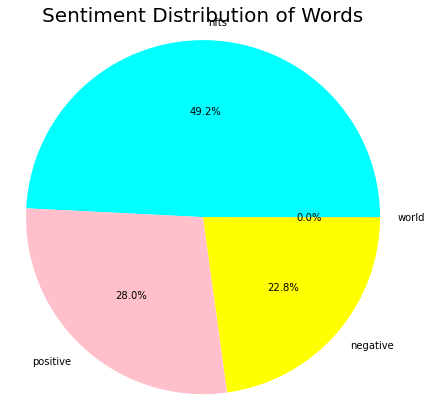

,index,sentiments
0,nfts,3800
1,positive,2160
2,negative,1759
3,world,3


In [17]:
# Plotting pie chart of Sentiment Distribution of words
emotion = {0: "nfts",
           1: "negative",
           2: "positive",
           3: "world"}

words["sentiments"] = words["cluster"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink","yellow", "orange"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"],labels=df_pie["index"],radius=2,colors=colors,autopct="%1.1f%%")
plt.axis('equal')
plt.title("Sentiment Distribution of Words", fontsize=20)
plt.show()
df_pie

In [18]:
words_dict = dict(zip(words.words, words.cluster))

In [19]:
import pickle

with open('bad.pkl', 'wb') as f:
    pickle.dump(words_dict, f)